<p align = center  
<br>
<img src="https://res-5.cloudinary.com/crunchbase-production/image/upload/c_lpad,h_256,w_256,f_auto,q_auto:eco/v1455514364/pim02bzqvgz0hibsra41.png" align="center"><br><FONT FACE="times new roman" SIZE=6>
<b>Parcial #2</b>
<br>
<i><b>Autores:</b></i> <br>
Juan Pablo Barrios Suarez<br>Juan Manuel Vásquez <br>Paula Sofia Godoy<br>Juan Pablo Cortés<br>9º semestre
<br>
<i><b>Asignatura:</b></i> Vida Artificial
<br>
<i><b>Docente:</b></i> Juan Pablo Ospina
<br>
<i><b>Fecha: </b>04/05/2022
<br>
<b>Ciencias de la computación e inteligencia artificial</b></i>
<br>
</FONT>
</p>

#**Biblioteca**

## **Importación de modulos**

In [ ]:
import types
import random
import inspect
import requests
import numpy as np
from PIL import Image
import seaborn as sns
from numba import jit
from io import BytesIO
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## **Clases abstractas**

In [ ]:
class Mutation(ABC):
  @abstractmethod
  def mutate(self):
    raise NotImplementedError()
class Selection(ABC):
  @abstractmethod
  def select(self):
    raise NotImplementedError()
class Cross(ABC):
  @abstractmethod
  def cross(self):
    raise NotImplementedError()        

## **Implementación de métodos de Selección**

In [ ]:
class SelectionRW(Selection):
  def select(population,fitness):    
    prob = fitness / sum(fitness)
    chosen = np.random.choice(len(population), size=len(population),
                              replace=True, p=prob)
    return population[chosen]



class SelectionSUS(Selection):
  def select(population, fitness):
    prob = fitness / sum(fitness)
    
    n = len(population)
    r = np.random.uniform() / n
    chosen = np.empty((n, population.shape[1]), dtype=population.dtype)
    acum = prob[0]
    i = 0
    for j in range(n):
        while r <= acum:
            chosen[j] = population[i]
            r += 1/n
        i = (i + 1) % n
        acum += prob[i]
    return chosen



class SelectionRB(Selection):
  def select(population,fitness, rate=0.5):
    pop_sort = np.argsort(fitness)[::-1]
    r = np.empty_like(pop_sort)
    r[pop_sort] = np.arange(len(pop_sort))
    
    prob = (2 - rate) / len(population) + 2 * r * (rate - 1) /\
           (len(population) * (len(population) - 1))
    
    chosen = population[np.random.choice(len(population),
                                         size=len(population), p=prob)]
    return chosen



class SelectionT(Selection):
  def select(population,fitness, k=2):
    n = len(population)
    
    idx = np.random.choice(n, size=(n, k), replace=True)
    
    chosen = []
    for i in range(n):
        tournement = idx[i]
        
        fitness_ = fitness[tournement]
        winner_idx = np.argmax(fitness_)
        chosen.append(population[tournement[winner_idx]])

    return np.array(chosen)


## **Implementación de métodos de cruce**

In [ ]:
class CrossSingle(Cross):
  def cross(parents, crossover_rate=0.5):
    executed = False
    if np.random.rand() < crossover_rate:
      idx_br = []
      crossover_point = np.random.randint(1, parents.shape[1])
  
      child1 = np.concatenate((parents[0, :crossover_point],
                              parents[1, crossover_point:]))
      child2 = np.concatenate((parents[1, :crossover_point],
                              parents[0, crossover_point:]))
      executed = True

      main_parent = np.random.choice(parents)
      temp=[]
      for i in range(len(main_parent)):
        if(main_parent[i]=="]" or main_parent[i]=="["):
          temp.append((i, main_parent[i]))
      
      list_char = ['F', '-', '+']

      for i in range(len(child1)):
        if child1[i] == "[" or child1[i] == "]":
          aux = np.random.choice(list_char)
          child1[i] = aux

        if child2[i] == "[" or child1[i] == "]":
          aux = np.random.choice(list_char)
          child2[i] = aux 
      
      for i, c in enumerate(temp):
        if i == c[0]:
          child1[i] = c[1]
          child2[i] = c[1]

      return child1, child2, executed

    else:

      return parents[0], parents[1], executed 

class CrossDouble(Cross):
  def cross(parents, crossover_rate=0.5):
    executed = False
    if np.random.rand() < crossover_rate:
      crossover_points = np.sort(np.random.choice(parents.shape[1],
                                                  size=2, replace=False))

      child1 = np.concatenate((parents[0, :crossover_points[0]],
                              parents[1, crossover_points[0]:crossover_points[1]],
                              parents[0, crossover_points[1]:]))
      child2 = np.concatenate((parents[1, :crossover_points[0]],
                              parents[0, crossover_points[0]:crossover_points[1]],
                              parents[1, crossover_points[1]:]))
      executed = True
      return child1, child2, executed 
    else:
      return parents[0], parents[1], executed 
  
class CrossUniform(Cross):
  def cross(parents, crossover_rate=0.5):
    executed = False
    if np.random.rand() < crossover_rate:
      mask = np.random.choice([False, True], size=len(parents[0]), p=[0.5, 0.5])
      child1 = np.where(mask, parents[1], parents[0])
      child2 = np.where(mask, parents[0], parents[1])
      executed = True
      return child1, child2, executed 
    else:
      return parents[0], parents[1], executed 

## **Implementación de métodos de mutación**

In [ ]:
class MutationFlip(Mutation):
  def mutate(population, mutation_rate=0.5):
    mutated_individual = np.copy(population)
    list_choice = ["F", "+", "-"]
    abro = "["
    cierro = "]"
    index_flip = 0
    choice=""
    for i in range(mutated_individual.shape[0]):
      if not(mutated_individual[i] == abro or mutated_individual[i] == cierro):
        if np.random.random() < mutation_rate:
          mutated_individual[i]=np.random.choice([x for x in list_choice if x != mutated_individual[i]])

      return mutated_individual

class MutationScramble(Mutation):
  def mutate(population, mutation_rate=0.5):
    mutated_population = np.copy(population)
    for i in range(population.shape[0]):
        if np.random.random() < mutation_rate:
            start = np.random.randint(0, population.shape[0] - 1)
            end = np.random.randint(start + 1, population.shape[0])
            scramble = np.random.permutation(mutated_population[start:end+1])
            mutated_population[start:end+1] = scramble

    return mutated_population

class MutationSwap(Mutation):
  def mutate(population, mutation_rate=0.5):
    mutated_population = np.copy(population)  
    for i in range(population.shape[0]):
      if np.random.random() < mutation_rate:
        j = np.random.randint(population.shape[0]-1)
        if not(mutated_population[i]=="[" or mutated_population[i]=="]"
            or mutated_population[j]=="[" or mutated_population[j]=="]"):
          mutated_population[i], mutated_population[j] = mutated_population[j], mutated_population[i]        
    return mutated_population

class MutationInversion(Mutation):
  def mutate(population, mutation_rate=0.5):
    mutated_population = np.copy(population)
    for i in range(population.shape[0]):
        if np.random.random() < mutation_rate:
            start = np.random.randint(0, population.shape[0] - 1)
            end = np.random.randint(start + 1, population.shape[0])
            mutated_population[start:end+1] = mutated_population[start:end+1][::-1]
            
    return mutated_population

## **Clase de validación de parametros**

In [ ]:
class check_classes:

  def check_selection(self,class_select):
    if isinstance(class_select, str):
      cases_RW=['roulette','rw']
      cases_RB=['rank','rb']
      cases_SUS=['sus','st_universal_sample']
      cases_T=['t','tournament']
      c_select=class_select.lower()

      if c_select in cases_RW:
        return SelectionRW
      elif c_select in cases_RB:
        return SelectionRB
      elif c_select in cases_SUS:
        return SelectionSUS
      elif c_select in cases_T:
        return SelectionT
      else:
        raise ValueError("Nombre invalido de la clase Selection")  
    elif isinstance(class_select, Selection):
      return class_select
    else:
      raise ValueError("class_selection debe ser un String o un objeto de la clase Selection") 

  def check_mutation(self,class_mut):
    if isinstance(class_mut, str):
      cases_F=['flip']
      cases_Sc=['scramble','scr']
      cases_Sw=['swap','sw']
      cases_I=['inversion','inv']
      c_select=class_mut.lower()

      if c_select in cases_F:
        return MutationFlip
      elif c_select in cases_Sc:
        return MutationScramble
      elif c_select in cases_Sw:
        return MutationSwap
      elif c_select in cases_I:
        return MutationInversion
      else:
        raise ValueError("Nombre invalido de la clase Mutation")    
    elif isinstance(class_mut, Mutation):
      return class_mut
    else:
      raise ValueError("class_selection debe ser un String o un objeto de la clase Mutation") 

  def check_cross(self,class_cross):
    if isinstance(class_cross, str):
      cases_S=['single']
      cases_D=['double']
      cases_U=['uniform']
      c_select=class_cross.lower()
      
      if c_select in cases_S:
        return CrossSingle
      elif c_select in cases_D:
        return CrossDouble
      elif c_select in cases_U:
        return CrossUniform
      else:
        raise ValueError("Nombre invalido de la clase Cross")   
    elif isinstance(class_cross, Cross):
      return class_cross
    else:
      raise ValueError("class_selection debe ser un String o un objeto de la clase Cross")

  def check_fitness_func(self,fitness_f):
    if isinstance(fitness_f,types.FunctionType):
      num_params = len(inspect.signature(fitness_f).parameters)
      if num_params <1 or num_params >1:
          raise ValueError("La función debe recibir un solo parámetro.")
      else:
        return fitness_f
    elif fitness_f == None:
      return lambda pob: sum(pob)
    else:
      raise ValueError("El atributo fitness_func debe ser del tipo function.")

## **Definición de la clase Población**

In [ ]:
class Population:
  def __init__(self,
               n=100,
               size=10,
               pop_r=[]
               ):
    self.n=n
    self.size=size
    self.pop_r = pop_r

  def init_population(self): 
    arr = np.array(self.pop_r)
    self.n_population=arr
    self.best_fitness_records=np.array([])
    self.worst_fitness_records=np.array([])
    self.best_ind = list()
    self.fitness = np.array([])
  
  def boxplot(self):
    plt.figure(figsize=(20,8))
    plt.boxplot(self.fitness)
    plt.title("$Diagrama\ de\ Caja\ del\ Fitness\ de\ la\ Población$")
    plt.ylabel("$Fitness$")
    plt.show()
  
  def mean_fitness(self):
    plt.figure(figsize=(20,8))
    plt.plot(self.fitness_records)
    plt.title('$Promedio\ de\ fitness\ a\ lo\ largo\ de\ las\ generaciones$')
    plt.xlabel('$Generación$')
    plt.ylabel('$Fitness$')
    plt.show()
  
  def hist_fitness(self):
    sns.histplot(self.fitness, kde=True)
    sns.set_style("whitegrid")
    sns.set(rc={"figure.figsize": (20, 8)})
    sns.set_palette("husl")
    plt.title('$Histograma\ de\ fitness\ a\ lo\ largo\ de\ las\ generaciones$')
    plt.xlabel('$Fitness$')
    plt.ylabel('$Frecuencia$')
    plt.show()
  
  def best_and_worst_fitness(self):
    plt.figure(figsize=(20,8))
    plt.plot(self.best_fitness_records, color="Blue", label="Mejor Fitness")
    plt.plot(self.worst_fitness_records, color="Red", label="Peor Fitness")
    plt.title('$Mejor\ y\ peor\ fitness\ a\ lo\ largo\ de\ las\ generaciones$')
    plt.xlabel('$Fitness$')
    plt.ylabel('$Frecuencia$')
    plt.legend()
    plt.show()
  
  def stats_describe(self):
    print("\t\t <<< RESUMEN ESTADÍSTICO >>> ")
    print("\n-> Media: [",self.fitness.mean(),"]")
    print("\n-> Mediana: [", np.median(self.fitness),"]")
    print("\n-> Desviación standard: [",self.fitness.std(),"]")
    print("\n-> Máximo: [",self.fitness.max(),"]")
    print("\n-> Mínimo: [",self.fitness.min(),"]")


## **Implementación de algoritmo genetico**

In [ ]:
class GeneticAlgorithm():
  def __init__(self,
               pop,
               max_gen=100,
               prob_mut=0.1,
               prob_cross=0.5,
               elite_size=0.5,
               random_state=None,
               fitness_func=None,
               class_select=None,
               class_cross=None,
               class_mut=None
               ):
    self.pop=pop
    self.max_gen=max_gen
    self.prob_mut=prob_mut
    self.prob_cross=prob_cross
    self.random_state=random_state
    self.elite_size = int(self.pop.n * elite_size)
    checker= check_classes()
    self.fitness_func=checker.check_fitness_func(fitness_func)
    self.class_select=checker.check_selection(class_select)
    self.class_cross=checker.check_cross(class_cross)
    self.class_mut=checker.check_mutation(class_mut)

  def run(self):
    self.pop.init_population()
    self.pop.fitness_records=np.array([])

    for i in tqdm(range(self.max_gen)):
      fitness_pop = np.array([self.fitness_func(x) for x in self.pop.n_population])
      elite = None
      if self.elite_size>0:
        elite = self.pop.n_population[np.argsort(fitness_pop)[::-1]][:self.elite_size]

      best_Fitness=max(fitness_pop)
      worst_Fitness=min(fitness_pop)
      self.pop.best_ind.append(self.pop.n_population[np.argmax(fitness_pop)])
      self.pop.best_fitness_records=np.append(self.pop.best_fitness_records, best_Fitness)
      self.pop.worst_fitness_records=np.append(self.pop.worst_fitness_records,worst_Fitness)

      self.pop.fitness_records=np.append(self.pop.fitness_records, fitness_pop.mean())

      size_pop=self.pop.n_population.shape[0]
      children=np.array([])

      for i in range(0, size_pop - self.elite_size, 2):
          selectionResults = self.class_select.select(self.pop.n_population, fitness_pop)
          parent1 = selectionResults[0]
          parent2 = selectionResults[1]
          parents = np.array([parent1, parent2])
          child1, child2, do_mutation = self.class_cross.cross(parents, self.prob_cross)

          if do_mutation:
            child1=self.class_mut.mutate(child1, mutation_rate=self.prob_mut)
            child2=self.class_mut.mutate(child2, mutation_rate=self.prob_mut)
            children=np.append(children,child1)
            children=np.append(children,child2)
          else:
            children=np.append(children,parent1)
            children=np.append(children,parent2)

      if self.elite_size>0:
        children = np.append(children, elite)
      children = children.reshape(self.pop.n_population.shape) 
      self.pop.n_population = children
    
    bestFitness = np.array([self.fitness_func(x) for x in self.pop.n_population])
    self.pop.best_ind = np.array(self.pop.best_ind)
    bestIndex = np.argmax(bestFitness)
    bestIndividual = self.pop.n_population[bestIndex]
    self.pop.fitness = bestFitness
    return bestIndividual, bestFitness[bestIndex]



In [ ]:
close_bracket = lambda n_max: np.random.randint(2, n_max)

def generate_axiom(keys, size):
    bracket = False
    rules = ['+', '[', '-'] 
    rules_2 = ['+', '-'] 
    rules.extend(keys)
    rules_2.extend(keys)
    choice = ""
    idx = -1
    idx_list = []
    num = 0
    axiom = list()

    for i in range(size):
      if bracket and idx_list[idx] == i:
        choice = "]"
        idx_list.pop(-1)
        idx -= 1
        if len(idx_list) == 0:
          bracket = False
      else:
        if i <= size-3 and not bracket:
          choice = np.random.choice(rules)
        else:
          choice = np.random.choice(rules_2) 

      if choice == "[":
        bracket = True
        if i == size-3:
          idx += 1
          idx_list.append(size-1)
          
        else:
          num = close_bracket(4)
          idx += 1
          idx_list.append(i + num)
      axiom.append(choice)

    return axiom

n = 10
size = 10

population_rules = []
for i in range(n):
  population_rules.append(generate_axiom(['F', 'G'], size))

In [ ]:
population_1 = Population(pop_r=population_rules)
population_1.init_population()

In [ ]:
fitness = lambda population: sum([5 if x == "[" else 1 for x in population])

model_1 = GeneticAlgorithm(population_1, class_select='rw',
                           class_cross='single', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.4,
                           fitness_func=fitness, max_gen=10000)
i, j = model_1.run()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
i

array(['[', 'F', 'F', ']', '-', 'F', '[', '-', ']', 'F'], dtype='<U32')

#**Implementación del ejercicio 1. (Letras en Numpy Array)**

In [ ]:
individual = np.array([[1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,	1, 0,	1, 1,	0, 0],
                       [1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,	0, 0,	1, 0,	1, 1],
                       [1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,	1, 0,	1, 1,	0, 1],
                       [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1,	1, 0,	1, 1,	1, 0],
                       [0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,	1, 0,	1, 0,	0, 1]])

def fitness (population):
  distance = 0
  for i in range(len(population)):
    if population[i] != individual[i]:
      distance += 1
  fitness = len(population) - distance
  return fitness

**Individuo objetivo**

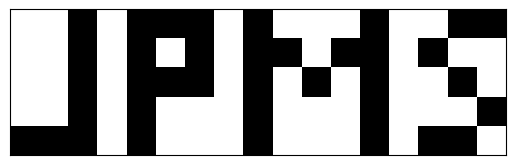

In [ ]:
plt.imshow(individual, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()

##**Experimento 1**

**Caracteristicas:**

- Método de selección: `Ruleta`

- Método de cruce: `Basado en dos puntos`

- Método de mutación: `Swap`

- Tasa de elitismo: `0.4`

- Número de generaciones: `1000`

- Probabilidad de cruce: `0.9`

- Probabilidad de mutación: `0.1`

In [ ]:
individual = individual.reshape(-1)
population_1 = Population(size=individual.shape[0])

model_1 = GeneticAlgorithm(population_1, class_select='rw',
                           class_cross='double', class_mut='swap',
                           prob_cross=0.9, prob_mut=0.1, elite_size=0.4,
                           fitness_func=fitness, max_gen=1000)
i, j = model_1.run()

  0%|          | 0/1000 [00:00<?, ?it/s]

**Resultado de visualizar el objetivo obtenido por el algoritmo**

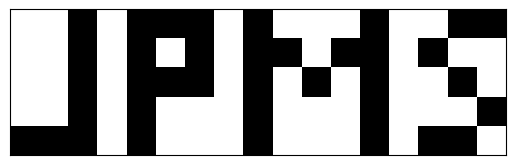

In [ ]:
plt.imshow(i.reshape(5, 17), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()

**Promedio de fitness a lo largo de las generaciones**

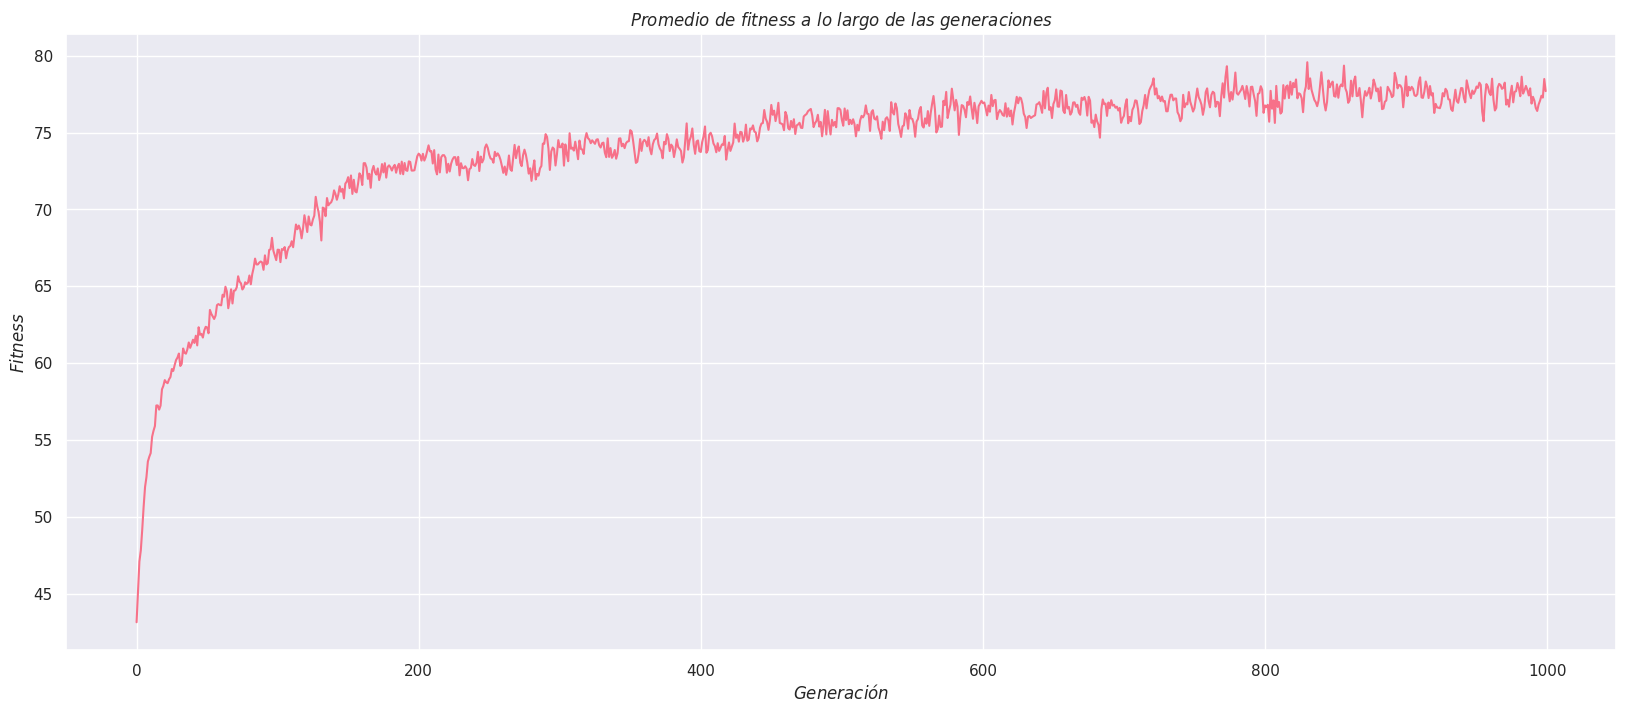

In [ ]:
population_1.mean_fitness()

**Histograma del fitness de la población**

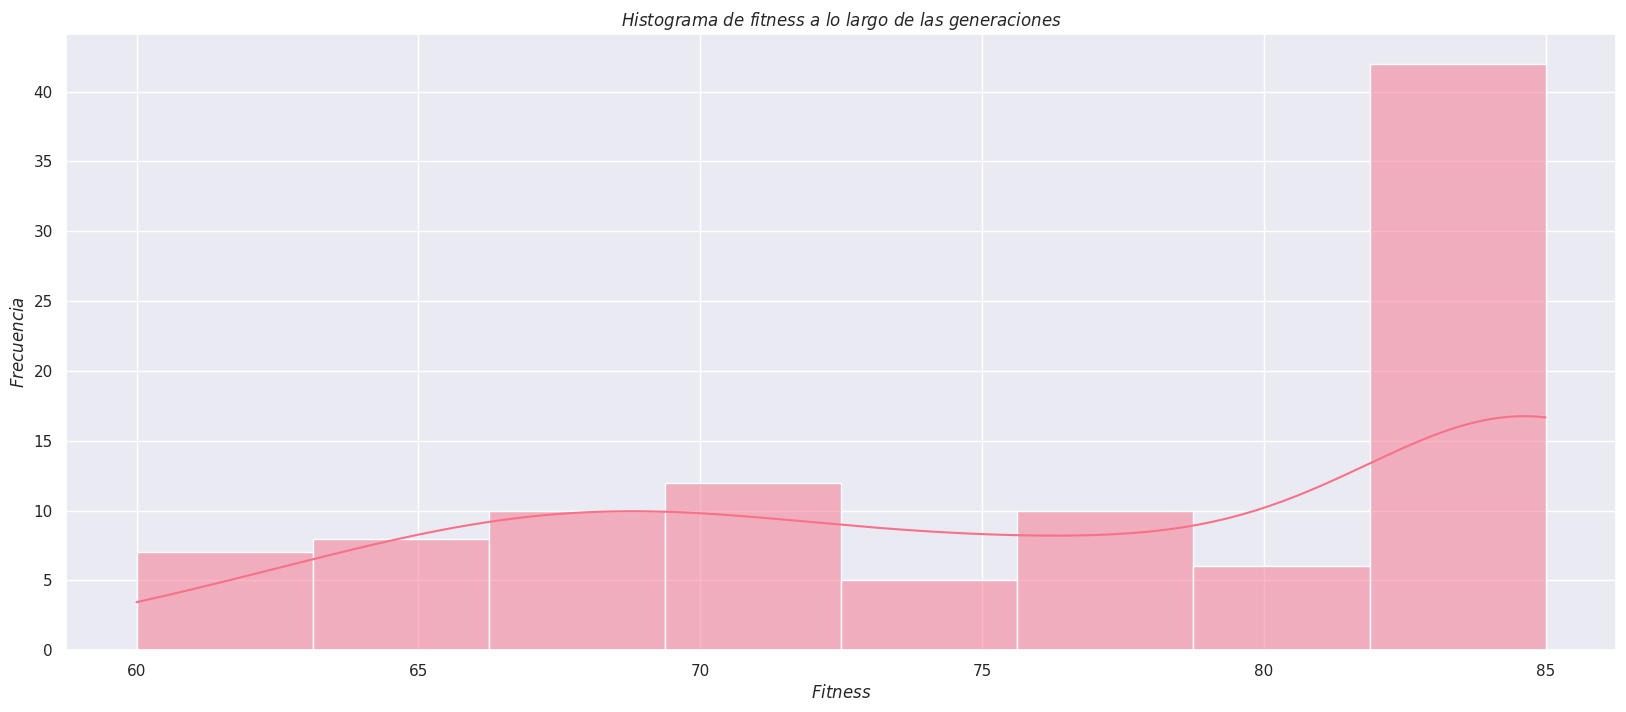

In [ ]:
population_1.hist_fitness()

**Diagrama de caja del fitness de una población**

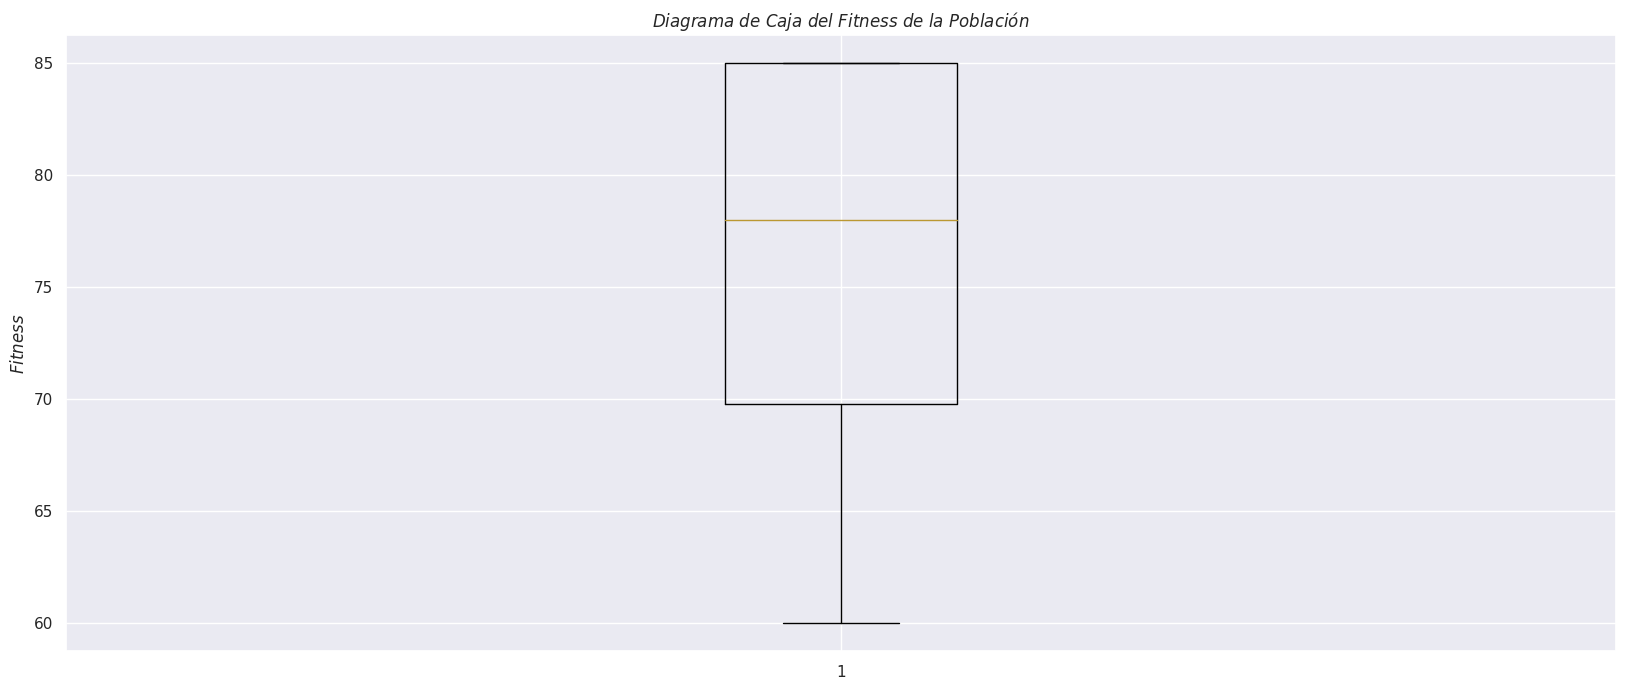

In [ ]:
population_1.boxplot()

**Fitness del mejor y peor individuo de la población**

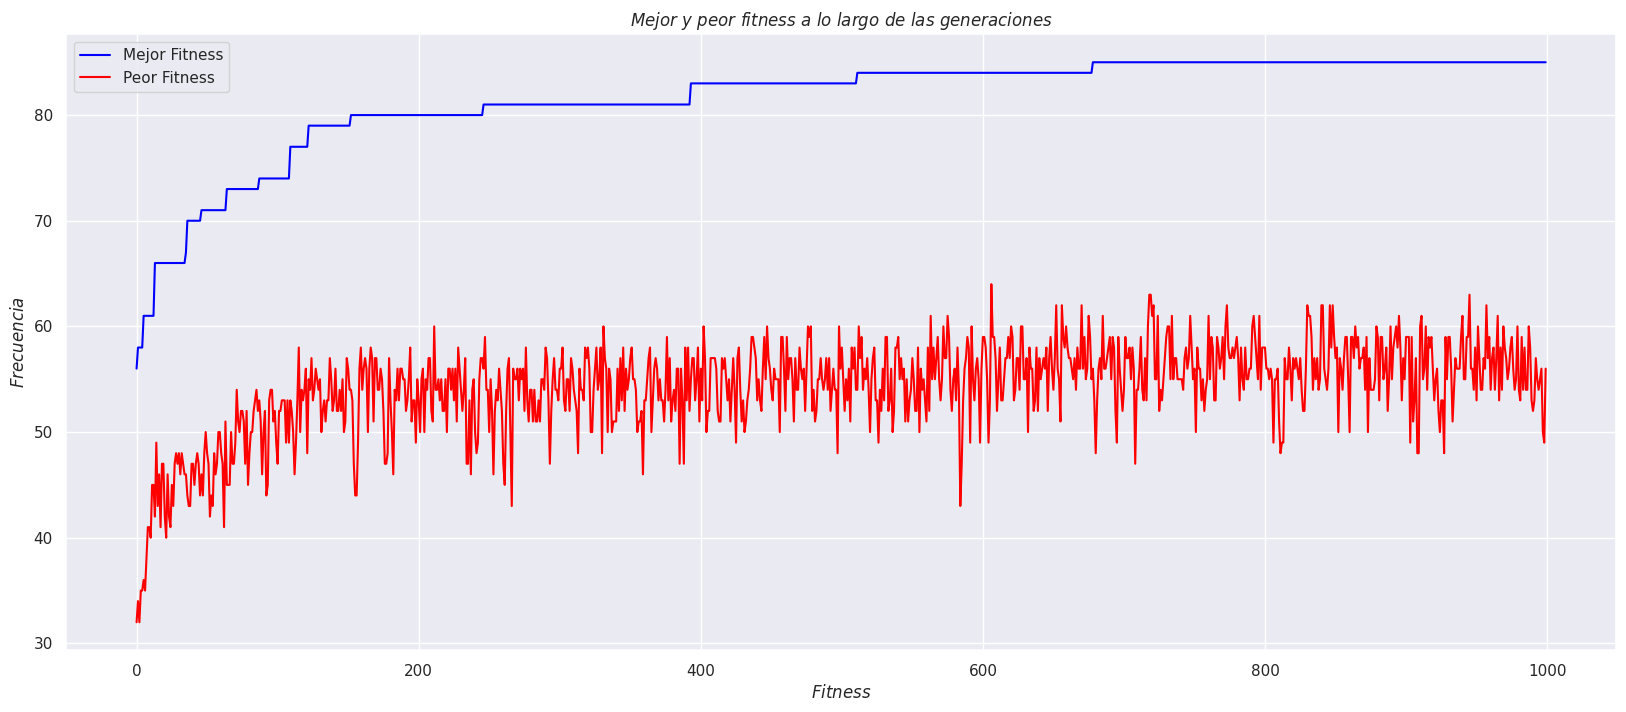

In [ ]:
population_1.best_and_worst_fitness()

**Resumen estadístico**

In [ ]:
population_1.stats_describe()

		 <<< RESUMEN ESTADÍSTICO >>> 

-> Media: [ 76.67 ]

-> Mediana: [ 78.0 ]

-> Desviación standard: [ 8.322325396185851 ]

-> Máximo: [ 85 ]

-> Mínimo: [ 60 ]


##**Análisis de resultados**

Luego de haber realizado una serie de experimentos probando distintos operadores genéticos y variando ciertos parámetros dentro del algoritmo se encontró lo siguiente:

1. El operador genético de mutación con el que se llego al individuo objetivo en la mayoria de los casos fue el de _swap_. Al realizar distintas variaciones en los operadores de selección y cruce, al haber mantenido la mutación con ese operador en específico, se pudo notar que el resultado no variaba, siempre se llegaba al individuo objetivo. De igual forma, se cambio el valor de ciertos parámetros como el número máximo de generaciones o la tasa de elitismo, y el resultado siempre fue un fitness de $85$ para el individuo arrojado por el algoritmo (fitness con el que tambien cuenta el individuo objetivo).

2. De igual forma, se pudo observar que el operador genético _flip-bit_ funciona mejor al aumentar el número de generaciones en el algoritmo, ya que al haber realizado distintas pruebas en las cuales se fueron cambiando los demas operadores genéticos, siempre se obtenía un fitness en el mejor individuo que variaba en un intervalo de $80-84$ (siendo 85 el más óptimo). Al aumentar el número de generaciones 10 veces más que la cantidad predeterminada, finalmente se pudo llegar al individuo objetivo.

3. Por otro lado, se pudo confirmar que hay dos operadores de mutación que no funcionan de la manera más óptima para este problema en específico, los cuales fueron _inversion_ y _scramble_. Sin importar que operador genético se usara en selección o cruce, el fitness arrojado por el algoritmo era considerablemente bajo con respecto a los otros dos operadores de mutación. Se probó con un aumento en el número de generaciones y la mejora en el fitness obtenida no fue la esperada, incrementando un máximo de 4 o 5 puntos con respecto al fitness obtenido anteriormente.

Es por lo anterior, que se recomienda lo siguiente con respecto a este caso en específico:

- En la mayoria de los casos se recomienda usar el operador de mutación _swap_.
- Si se quiere usar el operador de mutación por _flip-bit_, se recomienda usar un número de generaciones elevado.
- Los operadores de mutación por _scramble_ e _inversion_ deben evitarse en la medida de lo posible.
- Los operadores de selección y cruce en general funcionan bastante bien, por lo que la diferencia se puede encontrar al variar el operador de mutación. De igual forma se recomienda probar con cada uno de los que se encuentran disponibles para poder encontrar el rendimiento más óptimo.
- No se recomienda usar una tasa de elitismo baja.